In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import peak2 as peak
import pickle
from sklearn.linear_model import LinearRegression
import netCDF4

### Solar flare catalog based on SDO/AIA EUV images: composition and correlation with GOES/XRS X-ray flare magnitudes

This notebook generates the figures accompanying our paper, available [here](https://www.frontiersin.org/articles/10.3389/fspas.2022.1031211/full). 

In [26]:
def load_aia_data(flares,sharp):
    """
    Load AIA timeseries data for a given SHARP active region

    Args:
        flares (panda.DataFrame): flare catalog 
        sharp (int): SHARP Active Region number

    Returns:
        flares_sharp (panda.DataFrame): filtered flare catalog by SHARP
        aia_data (list): a list of 6 numpy arrays of summed intensity 
            values for each AIA wavelength 
        aia_times (list): corresponding times for the AIA timeseries 
            values for each wavelength
    """

    flares_sharp = flares[flares['SHARP']==sharp]
    print(len(flares_sharp),'flares associated with SHARP', sharp)

    with open('aia_timeseries/sharp_'+str(sharp)+'_aia_sum_intensity', "rb") as fp:   #Pickling
        aia_data = pickle.load(fp)
    with open('aia_timeseries/sharp_'+str(sharp)+'_aia_times', "rb") as fp:   #Pickling
        aia_times = pickle.load(fp)

    return flares_sharp,aia_data,aia_times

def plot_goes_flares(flares_sharp,ax):
    """
    Plot shaded window for duration of all GOES flares C5 and greater.

    Args:
        flares_sharp (pd.DataFrame): flare catalog
        ax: figure axis
    
    Returns: 
        None
    """
    for i in range(len(flares_sharp)):
        flare = flares_sharp.iloc[i]
        if flare['CMX'] == 'B' or (flare['CMX'] == 'C' and flare['CMX_VALUE'] <40):
            continue
        flare_date = str(flare.DATE)
        flare_start = str(flare.START_TIME).zfill(4)
        flare_end = str(flare.END_TIME).zfill(4)
        flare_start = datetime.strptime(flare_date+flare_start,'%y%m%d%H%M')
        flare_end = datetime.strptime(flare_date+flare_end,'%y%m%d%H%M')
        if flare_end < flare_start:
            flare_end = flare_end + timedelta(days=1)
        ax.axvspan(flare_start,flare_end,alpha=0.3,color='blue')

def plot_aia_data(peak_data,aia_data,aia_times,ax):
    """
    Plot AIA timeseries data and peak data for each wavelength

    Args:
        peak_data (pd.DataFrame): start, peak and end time of flares in each wavelength
        aia_data (list): summed pixel intensity timeseries for each wavelength
        aia_times (list): corresponding times for AIA data
        ax: figure axis
    
    Returns: 
        None
    """
    lams = ['193','171','304','1600','131','94']
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
    for j in range(len(lams)):
        lam = lams[j]
        color = colors[j]   
        sum_intensity = np.array(aia_data[j])
        times = np.array(aia_times[j])
        ax.plot(times,sum_intensity,'-',color=color,label=lam,alpha=1)
        ax.plot(peak_data[lam+'_peak_time'],peak_data[lam+'_magnitude'],'x',color='black',label='_')
        ax.plot(peak_data[lam+'_start_time'],peak_data[lam+'_magnitude']-peak_data[lam+'_prominence'],'.',color='black',label='_')

def plot_goes_data(goes_data,ax,offset,ylim,yticks,yticklabels,add_legend=False):
    """
    Plot GOES timeseries data 

    Args:
        goes_data (netCDF): contains time and flux data
        ax: figure axis
        offset: amount to offset GOES data by
        ylim (list): limits for y axis
        yticks (list): ticks for y axis
        yticklabels (list): tick labels for y axis 
        add_legend (bool): generate legend for figure
    
    Returns: 
        None
    """
    start_time = datetime(year=2000,month=1,day=1,hour=12)
    time= goes_data.variables['time'][:]
    time = np.array([start_time + timedelta(seconds=t) for t in time])
    data = np.array(goes_data.variables['xrsb_flux'][:])
    ax2 = ax.twinx()
    ax2.plot(time,data*0.7+offset,'k--',alpha=0.8,label='GOES-B')
    ax2.set_ylabel('XRS irradiance (W/m^2)',fontsize=16)
    ax2.set_ylim(ylim)
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(yticklabels,fontsize=14)
    if add_legend:
        ax2.legend(fontsize=16)

def set_plot_params(start,end,ax,title,ylim,add_legend=False):
    """
    Clean up sample flare plot

    Args:
        start (datetime): x limit on the left
        end (datetime): x limit on the right
        ax: figure axis
        title (str): for figure
        ylim (list): limits for y axis
        add_legend (bool): generate legend for figure
        
    Returns: 
        None
    """
    ax.set_xlim(start,end)
    if add_legend:
        ax.legend(loc='upper right',fontsize=16,ncol=2,facecolor='white',frameon=True,framealpha=1)
    ax.set_ylabel('AIA intensity (DN/s)',fontsize=16)
    ax.grid(True)
    ax.set_xlabel('Time (Day Hour:Min)',fontsize=16)
    ax.set_title(title)
    ax.set_ylim(ylim)

    plt.setp(ax.get_yticklabels(),fontsize=14)
    plt.setp(ax.get_xticklabels(),fontsize=14);
    plt.setp(ax.yaxis.get_offset_text(),fontsize=14)

def plot_time_hist(times,ax,hist_range,title):
    """
    Plot histogram of time data for comparison between AIA and GOES

    Args:
        times (list): list of 6 arrays of time data, one for each wavelength
        ax: figure axis
        hist_range (tuple/list): limits for histogram bins 
        title (str): for figure
        
    Returns: 
        None
    """
    lams = ['193','171','304','1600','131','94']
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']

    ax.set_xlabel('Minutes',fontsize=18)
    ax.set_ylabel('Number of M/X flares',fontsize=18)
    ax.set_title(title,fontsize=18)
    for i in range(len(lams)-1,-1,-1):
        ax.hist((times[~np.isnan(times)[:,i],i]),range=hist_range,bins=30,density=False,histtype='stepfilled',alpha=0.4,color=colors[i],label=lams[i])
        ax.hist((times[~np.isnan(times)[:,i],i]),range=hist_range,bins=30,density=False,histtype='step',alpha=1,linewidth=2,color=colors[i],label='_')
    ax.legend(fontsize=18)
    plt.setp(ax.get_yticklabels(),fontsize=16)
    plt.setp(ax.get_xticklabels(),fontsize=16)

def plot_predvstrue(y_train,y_train_pred,y_valid,y_valid_pred,ax,title):
    """
    Plot scatter of predicted vs. true flare magnitude values

    Args:
        y_train (list): true values for training data
        y_train_pred (list): predicted values for training data
        y_valid (list): true values for test data
        y_valid_pred (list): predicted values for test data
        ax: figure axis
        title (str): for figure
        
    Returns: 
        None
    """
    ax.plot(y_train*3-6,y_train_pred*3-6,'.',markersize=8)
    ax.plot(y_valid*3-6,y_valid_pred*3-6,'.',markersize=8)
    ax.plot(y_train*3-6,y_train*3-6,'k')
    dec = np.array([1,3,5])
    ax.set_xticks(ticks=np.log10(np.append(np.append(dec*1e-6,[dec*1e-5,dec*1e-4]),1e-3)))
    ax.set_xticklabels(['C1','C3','C5','M1','M3','M5','X1','X3','X5','X10'],fontsize=17)
    ax.set_yticks(ticks=np.log10(np.append(np.append(dec*1e-6,[dec*1e-5,dec*1e-4]),1e-3)))
    ax.set_yticklabels(['C1','C3','C5','M1','M3','M5','X1','X3','X5','X10'],fontsize=17)
    ax.set_xlabel('True (log intensity)',fontsize=20)
    ax.set_ylabel('Pred (log intensity)',fontsize=20)
    ax.legend(['Training','Test'],fontsize=20)
    ax.set_title(title,fontsize=20)
    ax.grid(True)

In [4]:
# AIA wavelengths and colors for plotting
lams = ['193','171','304','1600','131','94']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']

save_figs = False       # setting whether or not to save generated figures

In [5]:
### load AIA flare catalog
flare_catalog = pd.read_csv('flare_catalogs/aia_flares_catalog_verified.csv')

# convert columns to datetimes
flare_catalog['goes_start_time'] = pd.to_datetime(flare_catalog['goes_start_time'])
flare_catalog['goes_end_time'] = pd.to_datetime(flare_catalog['goes_end_time'])

for j in range(len(lams)):
    lam = lams[j]
    flare_catalog[lam+'_start_time'] = pd.to_datetime(flare_catalog[lam+'_start_time'])
    flare_catalog[lam+'_peak_time'] = pd.to_datetime(flare_catalog[lam+'_peak_time'])
    flare_catalog[lam+'_end_time'] = pd.to_datetime(flare_catalog[lam+'_end_time'])

# define min and max times for AIA flares
flare_catalog['aia_max_start_time']  = flare_catalog[[lam+'_start_time'for lam in lams]].max(axis=1)
flare_catalog['aia_min_end_time']  = flare_catalog[[lam+'_end_time'for lam in lams]].min(axis=1)
flare_catalog['aia_min_start_time']  = flare_catalog[[lam+'_start_time'for lam in lams]].min(axis=1)
flare_catalog['aia_max_end_time']  = flare_catalog[[lam+'_end_time'for lam in lams]].max(axis=1)

# sort catalog into flares with a GOES associations and flares without
flare_catalog_goes = flare_catalog[flare_catalog['goes_flare_ind'].notnull()]
flare_catalog_nogoes = flare_catalog[flare_catalog['goes_flare_ind'].isnull()]

In [6]:
### load GOES flare catalog and clean it
goes_catalog = pd.read_csv('flare_catalogs/goes_catalog_with_noaa_ar2.csv',na_values=' ')

# remove SHARPS < 20
goes_catalog = goes_catalog.dropna(subset=['SHARP'])
goes_catalog = goes_catalog[pd.to_numeric(goes_catalog['SHARP'])>=20]
goes_catalog.SHARP = pd.to_numeric(goes_catalog['SHARP']).astype('int64')

# remove SHARPS with bad headers
bhs = pd.read_csv('sharps_badheaders.csv')
bhs = [x[0] for x in bhs.values]
goes_catalog = goes_catalog[~goes_catalog.SHARP.isin(bhs)]

# remove flares that are on the limb (according to HMI data)
outofrange = pd.read_csv('flares_with_limbs2.csv')
outofrange = [x[0] for x in outofrange.values]
goes_catalog = goes_catalog.drop(outofrange,errors='ignore')

# remove SHARPs without an associated NOAA active region
nes_noaa = pd.read_csv('nonempty_sharps_with_noaa_ar.csv')
goes_catalog = goes_catalog[goes_catalog.SHARP.isin(nes_noaa.HARPNUM)]
goes_catalog = goes_catalog.reset_index().rename(columns={'index':'flare_ind'})

# convert columns to datetimes and fill missing peak times with start times instead
goes_catalog['goes_start_time'] = pd.to_datetime('20' + goes_catalog['DATE'].astype('str') + '_' + 
                                        goes_catalog['START_TIME'].astype('str').str.zfill(4) + '00', format='%Y%m%d_%H%M%S')
inds_null_peak = goes_catalog['MAX_TIME'].isnull()
goes_catalog['MAX_TIME'][inds_null_peak] = '0000'
goes_catalog['goes_peak_time'] = goes_catalog['goes_start_time']
goes_catalog['goes_peak_time'][~inds_null_peak] = pd.to_datetime('20' + goes_catalog['DATE'][~inds_null_peak].astype('str') + '_' + 
                                        goes_catalog['MAX_TIME'][~inds_null_peak].astype('str').str.zfill(4).str.strip('.0') + '00', format='%Y%m%d_%H%M%S')                                        
goes_catalog['goes_peak_time'][goes_catalog['goes_peak_time']<goes_catalog['goes_start_time']] = goes_catalog['goes_peak_time'][goes_catalog['goes_peak_time']<goes_catalog['goes_start_time']]+timedelta(days=1)
goes_catalog['goes_peak_time'][inds_null_peak] = pd.NaT
goes_catalog['goes_end_time'] = pd.to_datetime('20' + goes_catalog['DATE'].astype('str') + '_' + 
                                        goes_catalog['END_TIME'].astype('str').str.zfill(4) + '00', format='%Y%m%d_%H%M%S')
goes_catalog['goes_end_time'][goes_catalog['goes_end_time']<goes_catalog['goes_start_time']] = goes_catalog['goes_end_time'][goes_catalog['goes_end_time']<goes_catalog['goes_start_time']]+timedelta(days=1)

30 flares associated with SHARP 211
33 flares associated with SHARP 1834
21 flares associated with SHARP 3535
28 flares associated with SHARP 5011


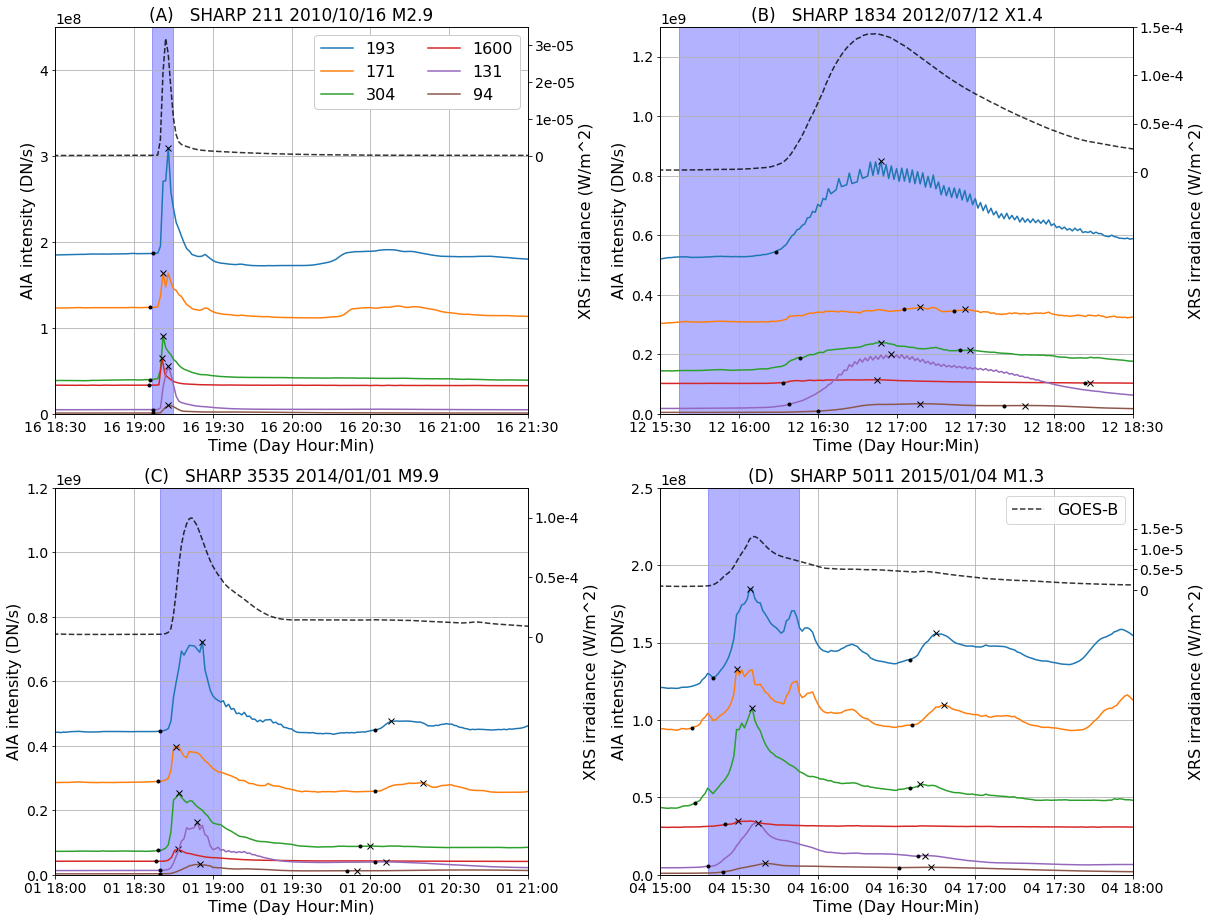

In [7]:
fig,ax = plt.subplots(2,2,figsize=(17,13))
plt.rcParams.update({'font.size': 14})

#--------------Panel A - SHARP 211 M2.9 Flare-----------------------#

# load AIA data
flares_sharp,aia_data,aia_times = load_aia_data(goes_catalog,211)
# load GOES data
goes_data = netCDF4.Dataset('goes_timeseries/sci_xrsf-l2-avg1m_g15_d20101016_v1-0-0.nc')

# plot GOES flares C5 and higher
plot_goes_flares(flares_sharp,ax[0,0])

# plot GOES data on twinned axis
plot_goes_data(goes_data,ax[0,0],offset=7e-5,ylim=[0,10.5e-5],yticks=[7e-5,8e-5,9e-5,10e-5],
    yticklabels=[0,1e-5,2e-5,3e-5])

# find peaks
peak_data = peak.generate_peak_data(aia_data,aia_times,lams, flares_sharp)

# plot AIA data and peaks for each wavelength
plot_aia_data(peak_data,aia_data,aia_times,ax[0,0])

# add last details to plot
start = datetime.strptime('1010161830','%y%m%d%H%M')
end = datetime.strptime('1010162130','%y%m%d%H%M')
title = '(A)   SHARP 211 2010/10/16 M2.9'
ylim = [-1,4.5e8]
set_plot_params(start,end,ax[0,0],title=title,ylim=ylim,add_legend=True)

#--------------Panel B - SHARP 1834 X1.4 Flare-----------------------#

# load AIA data
flares_sharp,aia_data,aia_times = load_aia_data(goes_catalog,1834)
# load GOES data
goes_data = netCDF4.Dataset('goes_timeseries/sci_xrsf-l2-avg1m_g15_d20120712_v1-0-0.nc')

# plot GOES flares C5 and higher
plot_goes_flares(flares_sharp,ax[0,1])

# plot GOES data on twinned axis
plot_goes_data(goes_data,ax[0,1],offset=2.5e-4,ylim=[0,4e-4],yticks=[2.5e-4,3e-4,3.5e-4,4e-4],
    yticklabels=['0','0.5e-4','1.0e-4','1.5e-4'])

# find peaks
peak_data = peak.generate_peak_data(aia_data,aia_times,lams, flares_sharp)

# plot AIA data and peaks for each wavelength
plot_aia_data(peak_data,aia_data,aia_times,ax[0,1])

# add last details to plot
start = datetime.strptime('1207121530','%y%m%d%H%M')
end = datetime.strptime('1207121830','%y%m%d%H%M')
title = '(B)   SHARP 1834 2012/07/12 X1.4'
ylim = [-1,13e8]
set_plot_params(start,end,ax[0,1],title=title,ylim=ylim)

#--------------Panel C - SHARP 3535 M9.9 Flare-----------------------#

# load AIA data
flares_sharp,aia_data,aia_times = load_aia_data(goes_catalog,3535)
# load GOES data
goes_data = netCDF4.Dataset('goes_timeseries/sci_xrsf-l2-avg1m_g15_d20140101_v1-0-0.nc')

# plot GOES flares C5 and higher
plot_goes_flares(flares_sharp,ax[1,0])

# plot GOES data on twinned axis
plot_goes_data(goes_data,ax[1,0],offset=2e-4,ylim=[0,3.25e-4],yticks=[2e-4,2.5e-4,3e-4],
    yticklabels=['0','0.5e-4','1.0e-4'])

# find peaks
peak_data = peak.generate_peak_data(aia_data,aia_times,lams, flares_sharp)

# plot AIA data and peaks for each wavelength
plot_aia_data(peak_data,aia_data,aia_times,ax[1,0])

# add last details to plot
start = datetime.strptime('140101180','%y%m%d%H%M')
end = datetime.strptime('1401012100','%y%m%d%H%M')
title = '(C)   SHARP 3535 2014/01/01 M9.9'
ylim = [-1,12e8]
set_plot_params(start,end,ax[1,0],title=title,ylim=ylim)

#--------------Panel D - SHARP 5011 M9.9 Flare-----------------------#

# load AIA data
flares_sharp,aia_data,aia_times = load_aia_data(goes_catalog,5011)
# load GOES data
goes_data = netCDF4.Dataset('goes_timeseries/sci_xrsf-l2-avg1m_g15_d20150104_v1-0-0.nc')

# plot GOES flares C5 and higher
plot_goes_flares(flares_sharp,ax[1,1])

# plot GOES data on twinned axis
plot_goes_data(goes_data,ax[1,1],offset=7e-5,ylim=[0,9.5e-5],yticks=[7e-5,7.5e-5,8e-5,8.5e-5],
    yticklabels=['0','0.5e-5','1.0e-5','1.5e-5'],add_legend=True)

# find peaks
peak_data = peak.generate_peak_data(aia_data,aia_times,lams, flares_sharp)

# plot AIA data and peaks for each wavelength
plot_aia_data(peak_data,aia_data,aia_times,ax[1,1])

# add last details to plot
start = datetime.strptime('1501041500','%y%m%d%H%M')
end = datetime.strptime('1501041800','%y%m%d%H%M')
title = '(D)   SHARP 5011 2015/01/04 M1.3'
ylim = [-1,2.5e8]
set_plot_params(start,end,ax[1,1],title=title,ylim=ylim)

plt.tight_layout(pad=1)

if save_figs:
    plt.savefig('figures/sample_flares.jpg',dpi=600,bbox_inches='tight')

Figure 1, above, shows 4 examples of GOES-associated flares as observed in AIA summed-pixel intensity time series (the method for detecting flares in the AIA flare catalog).

(A): a M2.9 flare in SHARP 211 on 2010/10/16 

(B): a X1.4 flare in SHARP 1834 on 2012/07/12 

(C): a M9.9 flare in SHARP 3535 on 2014/01/01

(D): a M1.3 flare in SHARP 5011 on 2015/01/04

The solid lines show the sum of the AIA pixel intensities over the AIA SHARP image for various wavelengths, the dashed line shows the GOES XRS-B intensity with the right hand y-axis for scale. The blue box depicts the time window of the flare specified in the GOES catalog. The black “x” markers indicate peaks as obtained by our peak finding procedure, and black “.” markers indicate start times. The AIA curves have not been shifted or normalized in these plots. Note that the AIA DN/s scales are different for each plot. The oscillations in the 193 Å and 131 Å curves in panel (B) are due to undercompensation for the AIA auto-exposure function.

In [8]:
# filter both AIA and GOES flare catalog using manually generated limb data (start and end times of SHARPs)

limbdata = pd.read_csv('sharps_limbs_data.csv')
limbdata['Start Time'] = pd.to_datetime(limbdata['Start Time'])
limbdata['End Time'] = pd.to_datetime(limbdata['End Time'])

print('AIA flare catalog before limb filtering: \n GOES, no GOES:',len(flare_catalog_goes),len(flare_catalog_nogoes))
print('C:',sum(flare_catalog['ert_pred_CMX']=='C'),'M:',sum(flare_catalog['ert_pred_CMX']=='M'),'X:',sum(flare_catalog['ert_pred_CMX']=='X'))

flare_catalog = flare_catalog.merge(limbdata,how='left',on='SHARP')

flarewithlimbs = flare_catalog[np.logical_or(flare_catalog['aia_max_end_time']<flare_catalog['Start Time'],flare_catalog['aia_min_start_time']>flare_catalog['End Time'])]
print('Total AIA flares on the limb:',len(flarewithlimbs))
print('C:',np.sum(flarewithlimbs['ert_pred_CMX']=='C'),'M:',np.sum(flarewithlimbs['ert_pred_CMX']=='M'),'X:',np.sum(flarewithlimbs['ert_pred_CMX']=='X'))

flare_catalog = flare_catalog[np.logical_and(flare_catalog['aia_max_end_time']>=flare_catalog['Start Time'],flare_catalog['aia_min_start_time']<=flare_catalog['End Time'])]
flare_catalog_goes = flare_catalog[flare_catalog['goes_flare_ind'].notnull()]
flare_catalog_nogoes = flare_catalog[flare_catalog['goes_flare_ind'].isnull()]
print('AIA flare catalog after filtering limb flares: \n GOES, no GOES:',len(flare_catalog_goes),len(flare_catalog_nogoes))
print('C:',sum(flare_catalog['ert_pred_CMX']=='C'),'M:',sum(flare_catalog['ert_pred_CMX']=='M'),'X:',sum(flare_catalog['ert_pred_CMX']=='X'))

print('GOES catalog before new limb filtering:',len(goes_catalog))
print('B:',sum(goes_catalog['CMX']=='B'),'C:',sum(goes_catalog['CMX']=='C'),'M:',sum(goes_catalog['CMX']=='M'),'X:',sum(goes_catalog['CMX']=='X'))

goes_catalog = goes_catalog.merge(limbdata,how='inner',on='SHARP')
goes_catalog = goes_catalog[np.logical_and(goes_catalog['goes_end_time']>=goes_catalog['Start Time'],goes_catalog['goes_start_time']<=goes_catalog['End Time'])]

print('GOES catalog after new limb filtering:',len(goes_catalog))
print('B:',sum(goes_catalog['CMX']=='B'),'C:',sum(goes_catalog['CMX']=='C'),'M:',sum(goes_catalog['CMX']=='M'),'X:',sum(goes_catalog['CMX']=='X'))


AIA flare catalog before limb filtering: 
 GOES, no GOES: 2954 13522
C: 15269 M: 381 X: 21
Total AIA flares on the limb: 3607
C: 3384 M: 111 X: 5
AIA flare catalog after filtering limb flares: 
 GOES, no GOES: 2436 10308
C: 11885 M: 270 X: 16
GOES catalog before new limb filtering: 4959
B: 1807 C: 2825 M: 305 X: 22
GOES catalog after new limb filtering: 3496
B: 968 C: 2269 M: 243 X: 16


In [9]:
### filter M/X flares in both catalogs
flares_MX = flare_catalog_goes[flare_catalog_goes['goes_magnitude']>=1e-5]
print(len(flares_MX), 'M/X flares in both the AIA and GOES catalog')

255 M/X flares in both the AIA and GOES catalog


In [10]:
### Calculate time differences between AIA start/peak times and GOES start/peak times
starts = np.zeros((len(flares_MX),len(lams)))
ends = np.zeros((len(flares_MX),len(lams)))
peaks = np.zeros((len(flares_MX),len(lams)))
peaks2 = np.zeros((len(flares_MX),len(lams)))
peak_times = []
for k in flares_MX.index:
    flare = flares_MX.loc[k]
    if len(goes_catalog['goes_peak_time'][goes_catalog['flare_ind']==flare['goes_flare_ind']]) > 0:
        peak_times.append(goes_catalog['goes_peak_time'][goes_catalog['flare_ind']==flare['goes_flare_ind']].iloc[0])
    else:
        peak_times.append(pd.NaT)
flares_MX['goes_peak_time'] = peak_times

for j in range(len(lams)):
    lam = lams[j]
    flares_MX[lam+'_starts'] = flares_MX[lam+'_start_time'].subtract(flares_MX['goes_start_time']).dt.total_seconds()/60
    flares_MX[lam+'_peaks'] = flares_MX[lam+'_peak_time'].subtract(flares_MX[lam+'_start_time']).dt.total_seconds()/60
    flares_MX[lam+'_peaks2'] = flares_MX[lam+'_peak_time'].subtract(flares_MX['goes_peak_time']).dt.total_seconds()/60
    flares_MX[lam+'_ends'] = flares_MX[lam+'_end_time'].subtract(flares_MX[lam+'_start_time']).dt.total_seconds()/60
    starts[:,j] = flares_MX[lam+'_starts']
    peaks[:,j] = flares_MX[lam+'_peaks']
    peaks2[:,j] = flares_MX[lam+'_peaks2']
    ends[:,j] = flares_MX[lam+'_ends']
    print(f"Difference between AIA {lam} and GOES start time (mean +/- std, median): {flares_MX[lam+'_starts'].mean(skipna=True):.2f} +/- {flares_MX[lam+'_starts'].std(skipna=True):.2f} min, {flares_MX[lam+'_starts'].median(skipna=True):.2f} min")
    print(f"Difference between AIA {lam} and GOES peak time (mean +/- std, median): {flares_MX[lam+'_peaks'].mean(skipna=True):.2f} +/- {flares_MX[lam+'_peaks'].std(skipna=True):.2f} min, {flares_MX[lam+'_peaks'].median(skipna=True):.2f} min")


Difference between AIA 193 and GOES start time (mean +/- std, median): 2.41 +/- 12.21 min, 0.00 min
Difference between AIA 193 and GOES peak time (mean +/- std, median): 14.22 +/- 15.70 min, 9.00 min
Difference between AIA 171 and GOES start time (mean +/- std, median): 2.72 +/- 14.78 min, 0.00 min
Difference between AIA 171 and GOES peak time (mean +/- std, median): 13.60 +/- 15.86 min, 7.00 min
Difference between AIA 304 and GOES start time (mean +/- std, median): -0.29 +/- 10.06 min, -1.00 min
Difference between AIA 304 and GOES peak time (mean +/- std, median): 13.61 +/- 15.01 min, 8.00 min
Difference between AIA 1600 and GOES start time (mean +/- std, median): 0.40 +/- 11.69 min, -1.00 min
Difference between AIA 1600 and GOES peak time (mean +/- std, median): 10.07 +/- 13.29 min, 6.00 min
Difference between AIA 131 and GOES start time (mean +/- std, median): 2.17 +/- 9.90 min, 0.00 min
Difference between AIA 131 and GOES peak time (mean +/- std, median): 13.66 +/- 10.49 min, 10.00

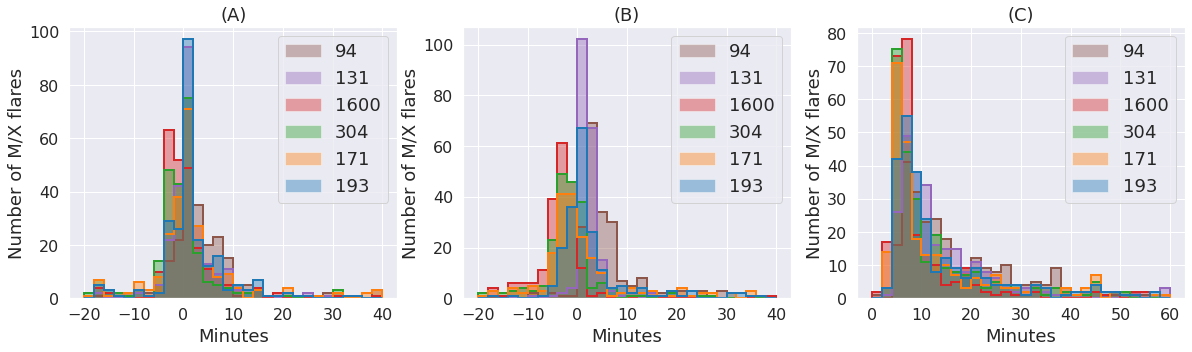

In [30]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
sns.set_theme()
plot_time_hist(starts,ax[0],hist_range=(-20,40),title='(A)')
plot_time_hist(peaks2,ax[1],hist_range=(-20,40),title='(B)')
plot_time_hist(peaks,ax[2],hist_range=(0,60),title='(C)')
plt.grid(True)

if save_figs:
    plt.savefig('figures/aiavsgoes_times_histogram2.jpg',dpi=600,bbox_inches='tight')

Figure 2, above, shows a comparison of start and peak times for flaring as measured in AIA. (A), discrepancy in minutes between AIA flare start times and GOES flare start times. (B), discrepancy in minutes between AIA flare peak times and GOES flare peak times (note that the GOES flare catalog does not contain peak times for flares after 2017/06/30 so we only include available data). (C), time between flare start and peak for AIA flares.

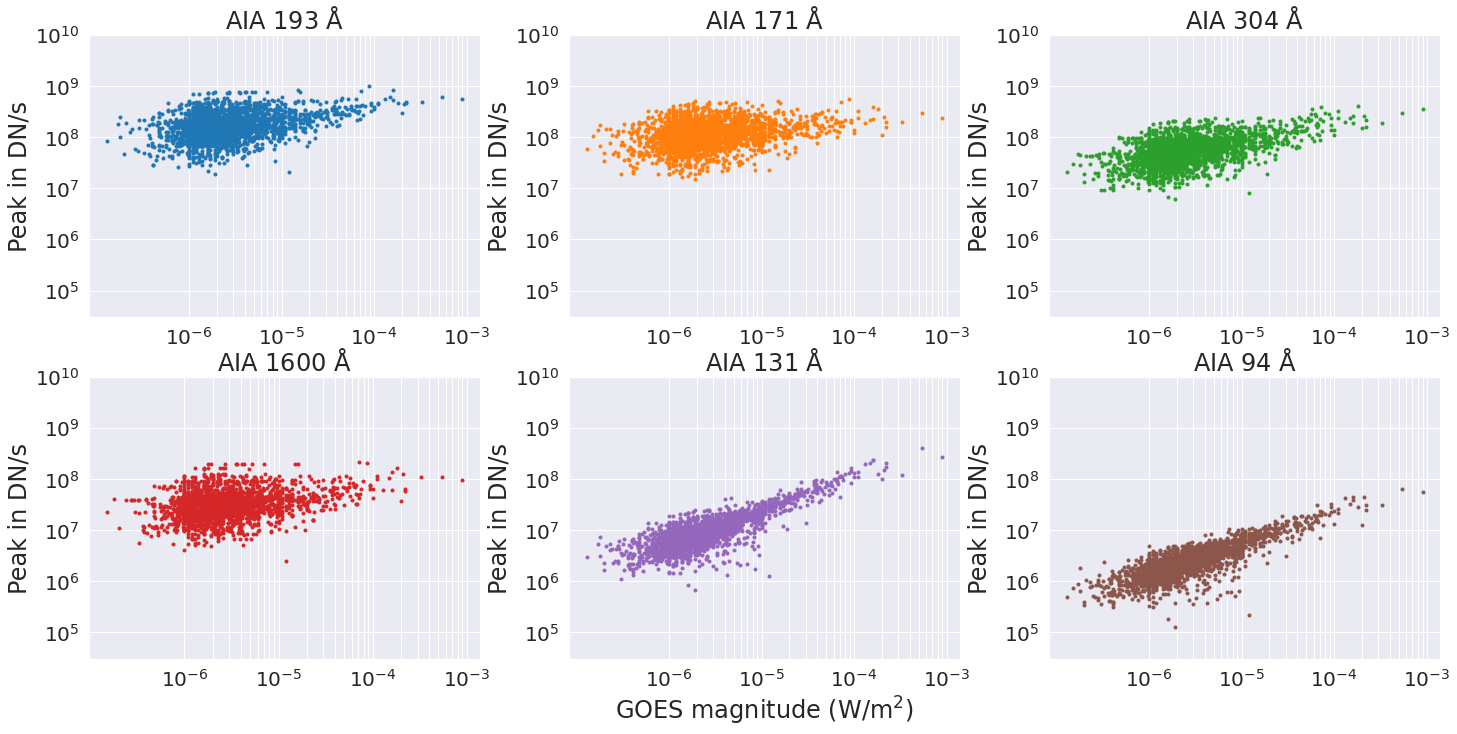

In [12]:
fig2,axs2 = plt.subplots(2,3,figsize=(20,10))
sns.set(palette='deep')
for j in range(len(lams)):
    ax = axs2[j//3,j-j//3*3]
    ax.loglog((flare_catalog_goes['goes_magnitude']),(flare_catalog_goes[lams[j]+'_magnitude']),'.',color=colors[j])
    ax.set_title('AIA '+lams[j] +' $\mathrm{\AA}$',fontsize=24)
    ax.set_ylabel('Peak in DN/s',fontsize=24)
    ax.set_ylim(3e4,1e10)
    ax.grid(True,axis='both')
    plt.setp(ax.get_yticklabels(),fontsize=20)
    dec = np.linspace(1,10,9,endpoint=False)
    ax.set_xticks(ticks=np.append(np.append(dec*1e-6,[dec*1e-5,dec*1e-4]),1e-3))
    ax.set_xticklabels(labels=['$10^{-6}$','','','','','','','','','$10^{-5}$','','','','','','','','','$10^{-4}$','','','','','','','','','$10^{-3}$'],fontsize=20)
axs2[1,1].set_xlabel('GOES magnitude (W/m$^2$)',fontsize=24)
plt.subplots_adjust(top =1,bottom=0,right=1,left=0,hspace=0,wspace=0)
plt.grid(True)
plt.tight_layout(pad=0)

if save_figs:
    plt.savefig('figures/aiapeaksvsgoespeaks_rawxray.jpg',dpi=600,bbox_inches='tight',pad_inches=0)

Figure 3, above, shows peak intensity in AIA wavelengths as a function of GOES flare magnitude. Units of AIA intensity are “Data Numbers” (DN) per second, i.e., raw detector output not calibrated to irradiance units. In all cases, decreasing GOES magnitude is associated with higher spread in AIA intensities. The 131 and 94 Å channels show the tightest correlation with GOES X-ray magnitudes.

In [13]:
### load results from training the ERT model to regress onto flare magnitudes
ert_results = pd.read_csv('ert_results_hmiandaia/seed10001/ert_results_hmiandaia_verified.csv')
ert_metrics = ert_results.iloc[:,:9]
ert_metrics

,seed,RMSE_train,MAE_train,R2_train,L2err_train,RMSE_test,MAE_test,R2_test,L2err_test
0,1001,0.076792,0.056884,0.968710,1.705736,0.146142,0.105689,0.893863,3.649041
1,2001,0.079056,0.057070,0.967437,1.772319,0.149343,0.104637,0.880852,3.060264
2,3001,0.076333,0.056330,0.969148,1.697297,0.139560,0.101631,0.902428,2.925630
3,4001,0.077096,0.056845,0.969296,1.708897,0.144790,0.103548,0.883969,3.379882
4,5001,0.076804,0.056509,0.969065,1.789476,0.145643,0.102788,0.889678,3.082294
5,6001,0.077013,0.056950,0.969144,1.605071,0.142264,0.100799,0.891356,3.583310
6,7001,0.076109,0.056106,0.969483,1.639380,0.158192,0.108818,0.872218,4.036918
7,8001,0.076906,0.056818,0.968606,1.697051,0.138878,0.097296,0.904287,3.051736
8,9001,0.078063,0.057234,0.968304,1.727774,0.144057,0.101681,0.888505,3.908352
9,10001,0.076791,0.056468,0.969114,1.693484,0.142146,0.102023,0.894387,3.308502


In [15]:
mean_metrics = np.mean(ert_metrics.iloc[:,1:],axis=0)
std_metrics = np.std(ert_metrics.iloc[:,1:],axis=0)
print('Mean:\n',mean_metrics)
print('Standard deviation:\n',std_metrics)

Mean:
 RMSE_train     0.077096
MAE_train      0.056721
R2_train       0.968831
L2err_train    1.703649
RMSE_test      0.145101
MAE_test       0.102891
R2_test        0.890154
L2err_test     3.398593
dtype: float64
Standard deviation:
 RMSE_train     0.000815
MAE_train      0.000336
R2_train       0.000571
L2err_train    0.051702
RMSE_test      0.005274
MAE_test       0.002931
R2_test        0.009127
L2err_test     0.364848
dtype: float64


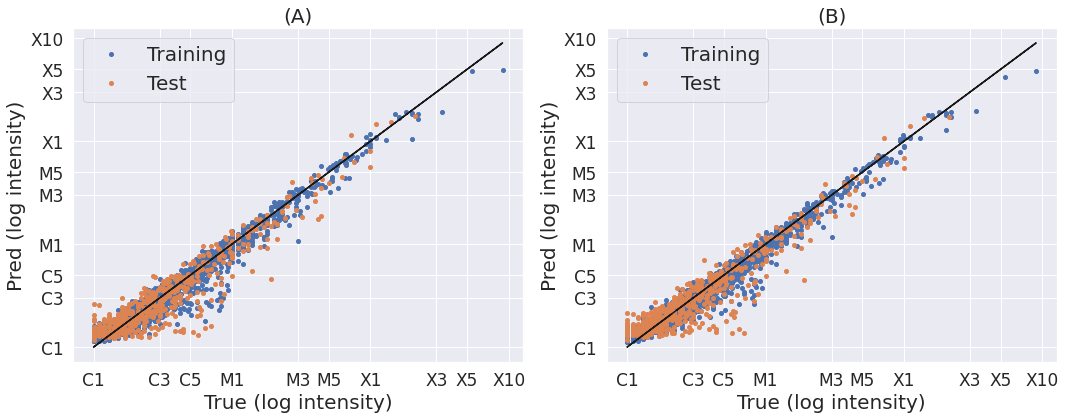

In [28]:
### load and plot results from a single seed
seed = 4001     # we choose the seed with results closest to the mean, calculated above

fig,ax = plt.subplots(1,2,figsize=(15,6))
sns.set_theme()

# results with AIA features only
y_train = np.load('ert_results_aia/seed'+str(seed)+'/train_true.npy')
y_train_pred = np.load('ert_results_aia/seed'+str(seed)+'/train_pred.npy')
y_valid = np.load('ert_results_aia/seed'+str(seed)+'/valid_true.npy')
y_valid_pred = np.load('ert_results_aia/seed'+str(seed)+'/valid_pred.npy')
plot_predvstrue(y_train,y_train_pred,y_valid,y_valid_pred,ax[0],'(A)')

# results with HMI and AIA features
y_train = np.load('ert_results_hmiandaia/seed'+str(seed)+'/train_true.npy')
y_train_pred = np.load('ert_results_hmiandaia/seed'+str(seed)+'/train_pred.npy')
y_valid = np.load('ert_results_hmiandaia/seed'+str(seed)+'/valid_true.npy')
y_valid_pred = np.load('ert_results_hmiandaia/seed'+str(seed)+'/valid_pred.npy')
plot_predvstrue(y_train,y_train_pred,y_valid,y_valid_pred,ax[1],'(B)')

plt.tight_layout()

if save_figs:
    plt.savefig('figures/ert_predvstrue_seed4001.jpg',dpi=600,bbox_inches='tight')


Figure 4, above, shows predicted vs. true flare magnitudes using AIA SHARPS features for both training and test data, (A) AIA SHARPs features only, (B) AIA and HMI SHARPs features. The closest seed to the mean result in Table 4 is depicted, which is a different split for each feature set.Figure 4, above, shows 

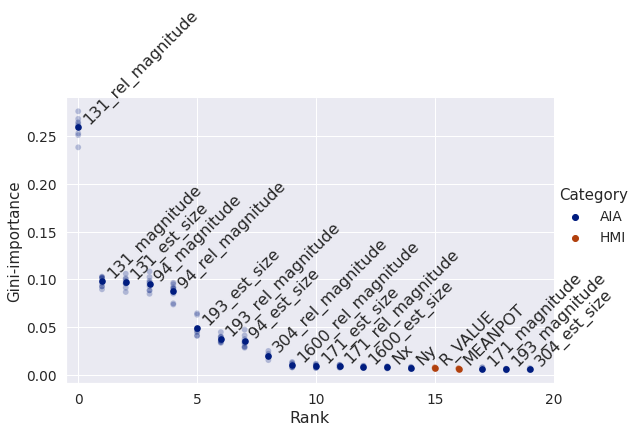

In [29]:
### plot feature ranking according to Gini importance for top 20 features
ert_features = ert_results.iloc[:,list(range(9,len(ert_results.columns)))]
mean_features = np.mean(ert_features.iloc[:,:],axis=0)
rank = np.argsort(mean_features)
ert_features = ert_features.iloc[:,rank[:27:-1]]
# replace features with rank
features = ert_features.columns
ert_features_long = ert_features.melt(var_name="Features",value_name="Gini-importance")
ert_features_long['Category'] = 0
ert_features_long.loc[ert_features_long.iloc[:,0] =='SIZE','Category'] = 'GOES'
ert_features_long.loc[ert_features_long.iloc[:,0].str.isupper(),'Category']='HMI'
ert_features_long.loc[~ert_features_long.iloc[:,0].str.isupper(),'Category'] = 'AIA'

sns.set(rc={'figure.figsize':(11.7,8.27)},font_scale=1.25)
_categories = ['AIA','HMI']
g = sns.relplot(data=ert_features_long, x='Features', y='Gini-importance',hue='Category',palette='dark',alpha=.25, aspect=1.61)
sns.pointplot(data=ert_features_long,x="Features",y="Gini-importance",hue='Category',palette='dark',join=False,scale=.75,ci=None)
plt.legend([],[],frameon=False)
plt.grid(True,axis='both')
plt.xticks(range(0,len(features)+1,5),range(0,len(features)+1,5))
plt.xlabel('Rank',fontsize=16)
features = pd.DataFrame({'Feature':features,'Rank':range(len(features)),'Gini-importance':mean_features[rank[:27:-1]]})
features.reset_index
for v in features.iterrows():
    plt.text(v[1][1] + 0.1, v[1][2] + 0.004, f'{v[1][0]}', rotation=45, fontsize=16)
    
if save_figs:
    plt.savefig('../figures/featureimportances_hmiandaia.jpg',dpi=600,bbox_inches='tight')


Figure 5, above, shows feature importance rankings for the experiment with both AIA and HMI SHARPs features (right). The results from each random seed are shown in faint colors, while the dark colored dots depict the average importance. Only the top 20 features are shown.